# CME538 - Introduction to Data Science
## Tutorial 8 - Classification, metrics, gridsearch

### Goals

In this tutorial, we would like to train a model to predict if it will rain tomorrow in Australia. 
As the answer to this question is either **YES** or **No** (binary), we can see this problem as a binary classification problem. To this end, we train a logitic classifier model.

### Tutorial Structure


1. [Exploratory Analysis](#section1)

2. [Preprocessing](#section2)

3. [Model Training](#section3)

4. [Model Evaluation](#section4)


***    
This notebook is mainly based on:


[[1]](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) Rain in Australia

[[2]](https://www.kaggle.com/prashant111/extensive-analysis-eda-fe-modelling/data) Extensive Analysis - EDA + Preprocessing + FE + Modelling

<a id='section0'></a>
## Setup Notebook
At the start of a notebook, we need to import the Python packages we plan to use.


In [235]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pylab as plt


from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

# Configure Notebook
#for plots to be inline
%matplotlib inline 
#for auto_complete 
%config Completer.use_jedi = False 
import warnings

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_context("notebook")

<a id='section1'></a>

# Exploratory analysis


In this step we import the dataset and explore its features. We use the Rain in Australia dataset for this tutorial. 

In [3]:
data = 'weatherAUS.csv'
df = pd.read_csv(data)

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Let's have a look at the dataset shape and some general info

In [6]:
df.shape

(145460, 23)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### Target Variable: 'RainTomorrow'


We are interested in the column 'RainTomrrow' which indicates whether we are going to have rain tomorrow or not.

In [9]:
df['RainTomorrow'].describe()

count     142193
unique         2
top           No
freq      110316
Name: RainTomorrow, dtype: object

We should always be careful about missing data

In [10]:
df['RainTomorrow'].unique()

array(['No', 'Yes', nan], dtype=object)

In [11]:
df['RainTomorrow'].isnull().sum()

3267

We can see that we are missing over 3000 values which is about 3 percent of our data. We need to remove these instances from our dataset.

In [13]:
df = df.dropna(subset=['RainTomorrow'])
df['RainTomorrow'].unique()

array(['No', 'Yes'], dtype=object)

Let's see how many of each value there is in the data set. We can plot this as well.

In [15]:
df['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

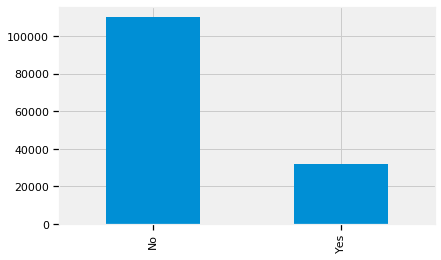

In [18]:
df['RainTomorrow'].value_counts().plot(kind='bar')

We can also use sns library for this purpose:

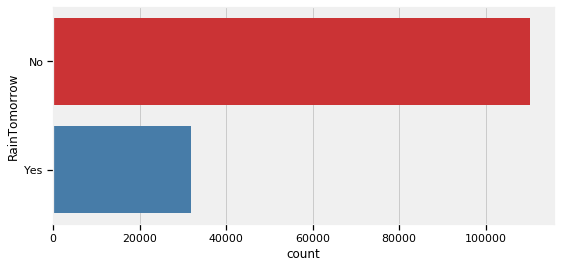

In [19]:
f, ax = plt.subplots(figsize=(8, 4))
ax = sns.countplot(y="RainTomorrow", data=df, palette="Set1")
plt.show()

Or, matplotlib:

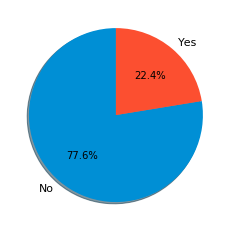

In [20]:
f, ax = plt.subplots(figsize=(8, 4))
sizes = df['RainTomorrow'].value_counts().values
ax.pie(sizes,labels=["No", "Yes"], autopct='%1.1f%%',
        shadow=True, startangle=90)
sns.set_palette("Set1", 8, .75)
plt.show()


### Categorical Vs Numerical

In later steps, we will need to develop a model where by using a set of features, we predict whether it's going to rain or not. These models are based on numerical analysis and as a reuslt, it is important that we check whether our features are numerical or not. 
If a feature is not numerical, we will need to find a way to convert it to one.

we can use the dtype method to capture the categorical features

In [29]:
categorical = [var for var in df.columns if df[var].dtype=='O']

# view the categorical variables

df[categorical].head()



,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No,No
1,2008-12-02,Albury,WNW,NNW,WSW,No,No
2,2008-12-03,Albury,WSW,W,WSW,No,No
3,2008-12-04,Albury,NE,SE,E,No,No
4,2008-12-05,Albury,W,ENE,NW,No,No


LEt's see if these features have missing vlues or not

In [33]:
print(df[categorical].isnull().sum())

Date                0
Location            0
WindGustDir      9330
WindDir9am      10013
WindDir3pm       3778
RainToday        1406
RainTomorrow        0
dtype: int64


Let's also check how many unique values each of the features have

In [35]:
for var in categorical:
    
    print(var, ': ', len(df[var].unique()))

Date :  3436
Location :  49
WindGustDir :  17
WindDir9am :  17
WindDir3pm :  17
RainToday :  3
RainTomorrow :  2


 A common approach for dealing with the categorical values is using encoding methods. See the image below, captured from https://www.kaggle.com/alexisbcook/categorical-variables

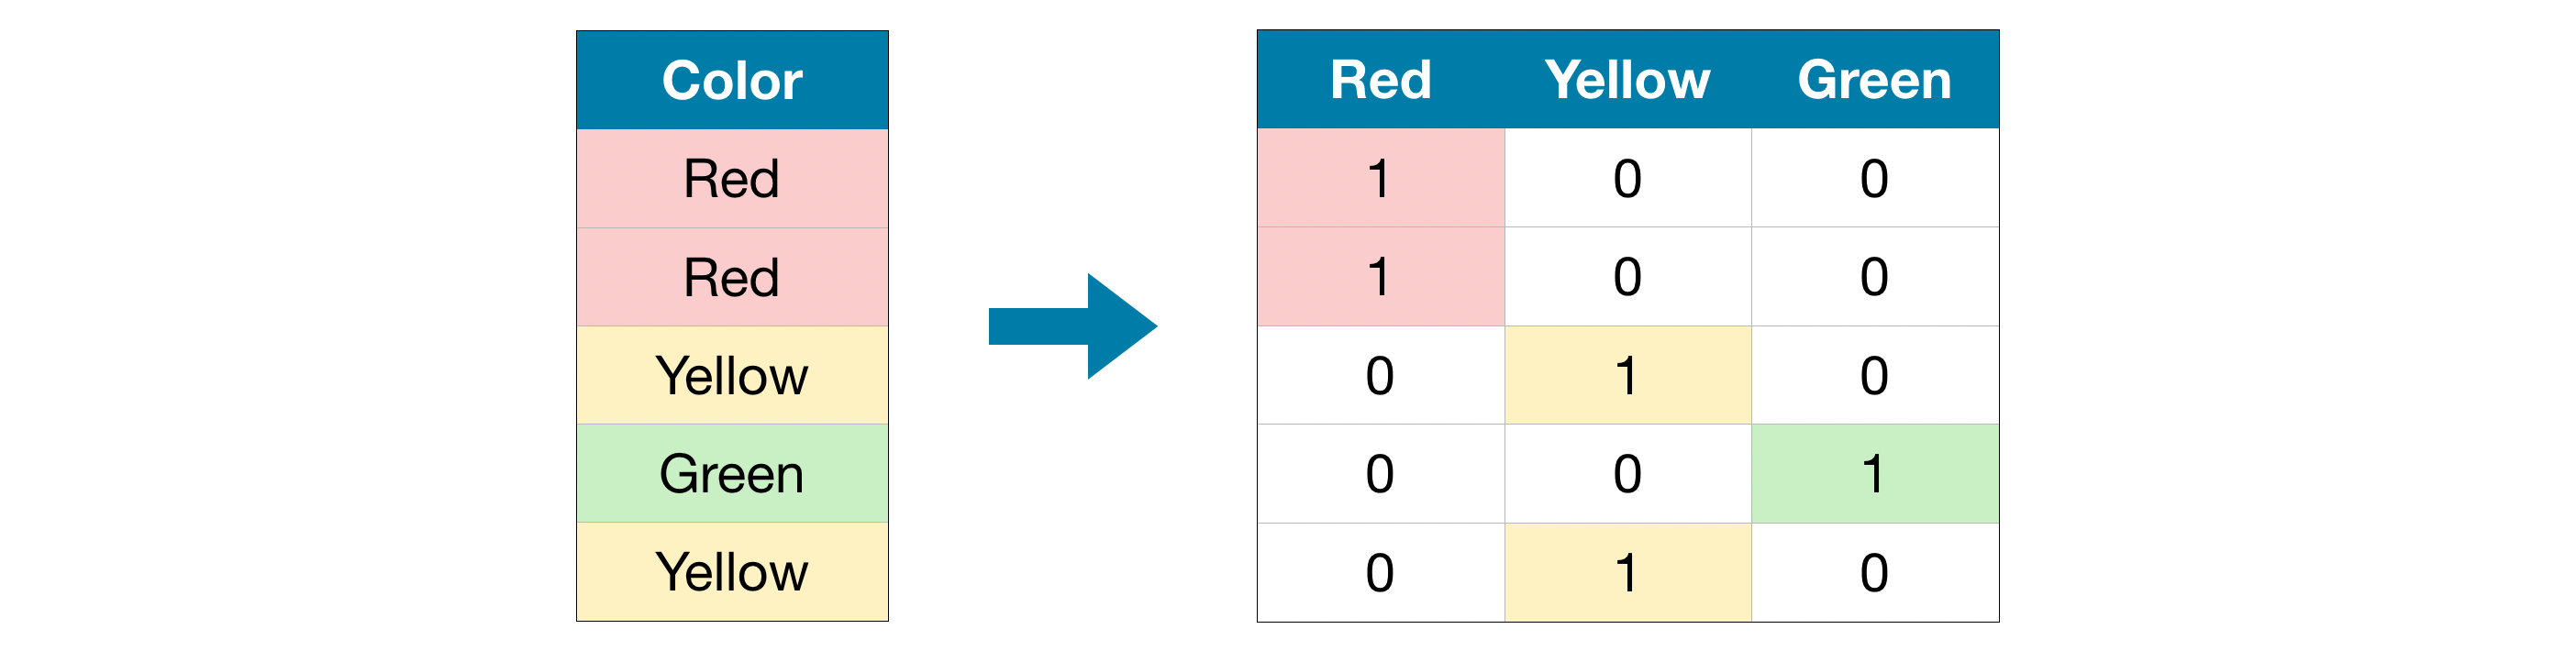

Obviously we cannot do this for the 'date' column right now. An alternatice is to reframe the date values into three columns of year, month, and day of month. This way we will have much less classes.

In [36]:
df['Date'] = pd.to_datetime(df['Date'])

# extract year from date

df['Year'] = df['Date'].dt.year

# extract month from date

df['Month'] = df['Date'].dt.month


# extract day from date

df['Day'] = df['Date'].dt.day

df.drop('Date', axis=1, inplace = True)

In [37]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,No,No,2008,12,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,No,No,2008,12,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,No,No,2008,12,3
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1012.8,NaN,NaN,18.1,26.5,No,No,2008,12,4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,5


Now let's have a look at numerical values

In [38]:
numerical = [var for var in df.columns if df[var].dtype!='O']

check missing values in numerical variables

In [39]:
df[numerical].isnull().sum()

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
Year                 0
Month                0
Day                  0
dtype: int64

The describe method is very helpful for numerical features

In [40]:
print(round(df[numerical].describe()),2)

        MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
count  141556.0  141871.0  140787.0      81350.0   74377.0       132923.0   
mean       12.0      23.0       2.0          5.0       8.0           40.0   
std         6.0       7.0       8.0          4.0       4.0           14.0   
min        -8.0      -5.0       0.0          0.0       0.0            6.0   
25%         8.0      18.0       0.0          3.0       5.0           31.0   
50%        12.0      23.0       0.0          5.0       8.0           39.0   
75%        17.0      28.0       1.0          7.0      11.0           48.0   
max        34.0      48.0     371.0        145.0      14.0          135.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
count      140845.0      139563.0     140419.0     138583.0     128179.0   
mean           14.0          19.0         69.0         51.0       1018.0   
std             9.0           9.0         19.0         21.0          7.0   
mi

we can see that the Rainfall, Evaporation, WindSpeed9am and WindSpeed3pm columns may contain outliers.

Text(0, 0.5, 'WindSpeed3pm')

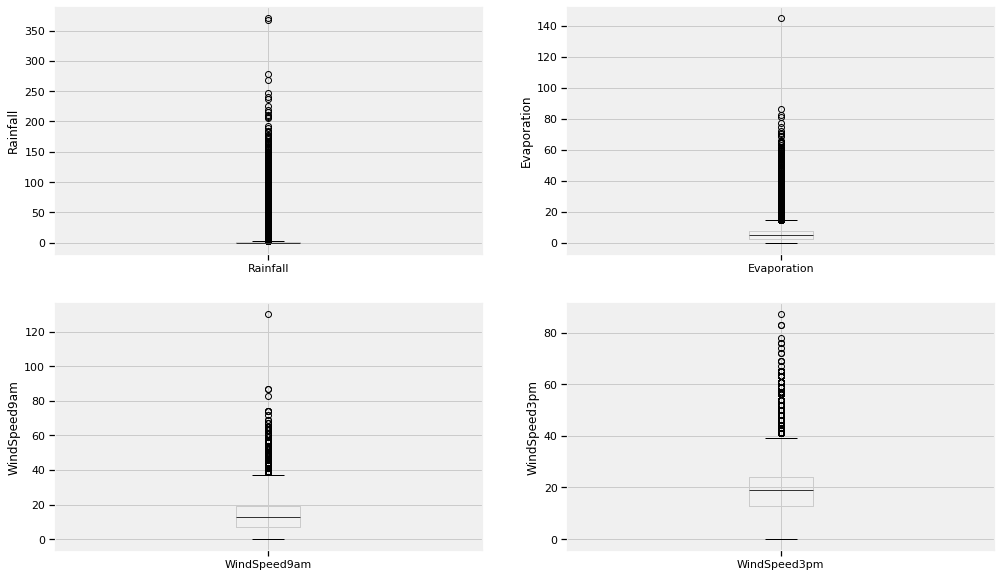

In [41]:
# draw boxplots to visualize outliers

plt.figure(figsize=(15,10))


plt.subplot(2, 2, 1)
fig = df.boxplot(column='Rainfall')
fig.set_title('')
fig.set_ylabel('Rainfall')


plt.subplot(2, 2, 2)
fig = df.boxplot(column='Evaporation')
fig.set_title('')
fig.set_ylabel('Evaporation')


plt.subplot(2, 2, 3)
fig = df.boxplot(column='WindSpeed9am')
fig.set_title('')
fig.set_ylabel('WindSpeed9am')


plt.subplot(2, 2, 4)
fig = df.boxplot(column='WindSpeed3pm')
fig.set_title('')
fig.set_ylabel('WindSpeed3pm')


How to describe outlier:
https://towardsdatascience.com/why-1-5-in-iqr-method-of-outlier-detection-5d07fdc82097

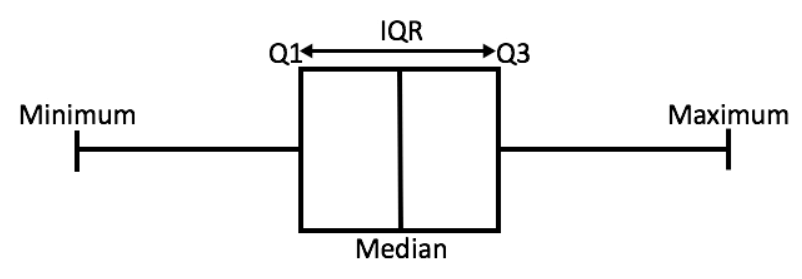

The difference between Q3 and Q1 is called the Inter-Quartile Range or IQR.

Decision range:

Lower Bound: (Q1 - 1.5 * IQR)

Upper Bound: (Q3 + 1.5 * IQR)

In [42]:
contain_outliers = ['Rainfall', 'Evaporation', 'WindSpeed9am' , 'WindSpeed3pm']
upper_lim_list = []
for col in contain_outliers:
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    Lower_lim = df[col].quantile(0.25) - (IQR * 1.5)
    Upper_lim = df[col].quantile(0.75) + (IQR * 1.5)
    upper_lim_list.append(Upper_lim)
    print('Outliers in {name} are < {lowerboundary:.2f} or > {upperboundary:.3f}'.format(name = col, lowerboundary=Lower_lim, upperboundary=Upper_lim))
    print('# of outliers: {:.2f} % \n ----'.format(df[df[col] > Upper_lim].shape[0]/df[col].shape[0]*100))

Outliers in Rainfall are < -1.20 or > 2.000
# of outliers: 17.74 % 
 ----
Outliers in Evaporation are < -4.60 or > 14.600
# of outliers: 1.37 % 
 ----
Outliers in WindSpeed9am are < -11.00 or > 37.000
# of outliers: 1.22 % 
 ----
Outliers in WindSpeed3pm are < -3.50 or > 40.500
# of outliers: 1.73 % 
 ----


In [61]:
outlier_dic = dict(zip(contain_outliers, upper_lim_list)) 

### Correlation Analysis

Relationships between features, and between features with target variable are very important in modeling processes.

In [44]:
correlation = df.corr()

In [45]:
correlation

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Year,Month,Day
MinTemp,1.000000,0.736267,0.104255,0.467261,0.072961,0.177285,0.176005,0.175749,-0.234211,0.005999,-0.451260,-0.461623,0.077625,0.020489,0.901813,0.708865,0.039245,-0.204279,0.001507
MaxTemp,0.736267,1.000000,-0.074839,0.588915,0.469967,0.067690,0.014680,0.050800,-0.505432,-0.509270,-0.332293,-0.427279,-0.289865,-0.279053,0.887020,0.984562,0.058388,-0.164622,-0.000495
Rainfall,0.104255,-0.074839,1.000000,-0.064549,-0.227525,0.133497,0.086816,0.057759,0.223725,0.255312,-0.168085,-0.126728,0.198195,0.171993,0.011477,-0.079178,-0.009284,-0.030863,0.001134
Evaporation,0.467261,0.588915,-0.064549,1.000000,0.366607,0.203001,0.193936,0.128895,-0.505890,-0.392785,-0.269907,-0.293160,-0.185032,-0.184287,0.545497,0.574275,0.084141,-0.027912,-0.007770
Sunshine,0.072961,0.469967,-0.227525,0.366607,1.000000,-0.032831,0.008040,0.056012,-0.491603,-0.629122,0.040959,-0.020464,-0.675610,-0.704202,0.291139,0.490180,0.011678,0.023885,-0.001173
WindGustSpeed,0.177285,0.067690,0.133497,0.203001,-0.032831,1.000000,0.604837,0.686419,-0.215461,-0.026663,-0.457891,-0.412922,0.071235,0.109088,0.150258,0.032970,-0.032708,0.060918,-0.009226
WindSpeed9am,0.176005,0.014680,0.086816,0.193936,0.008040,0.604837,1.000000,0.519971,-0.270807,-0.031607,-0.227923,-0.174916,0.024280,0.053584,0.129298,0.005108,-0.021620,0.051039,-0.009183
WindSpeed3pm,0.175749,0.050800,0.057759,0.128895,0.056012,0.686419,0.519971,1.000000,-0.145942,0.015903,-0.295567,-0.254988,0.052780,0.025269,0.163601,0.028567,-0.032806,0.061006,-0.009969
Humidity9am,-0.234211,-0.505432,0.223725,-0.505890,-0.491603,-0.215461,-0.270807,-0.145942,1.000000,0.667388,0.139519,0.186955,0.452182,0.358043,-0.472826,-0.499777,0.010708,-0.090564,0.015610
Humidity3pm,0.005999,-0.509270,0.255312,-0.392785,-0.629122,-0.026663,-0.031607,0.015903,0.667388,1.000000,-0.027449,0.051840,0.517037,0.523270,-0.221467,-0.557989,-0.009150,-0.018541,0.013207


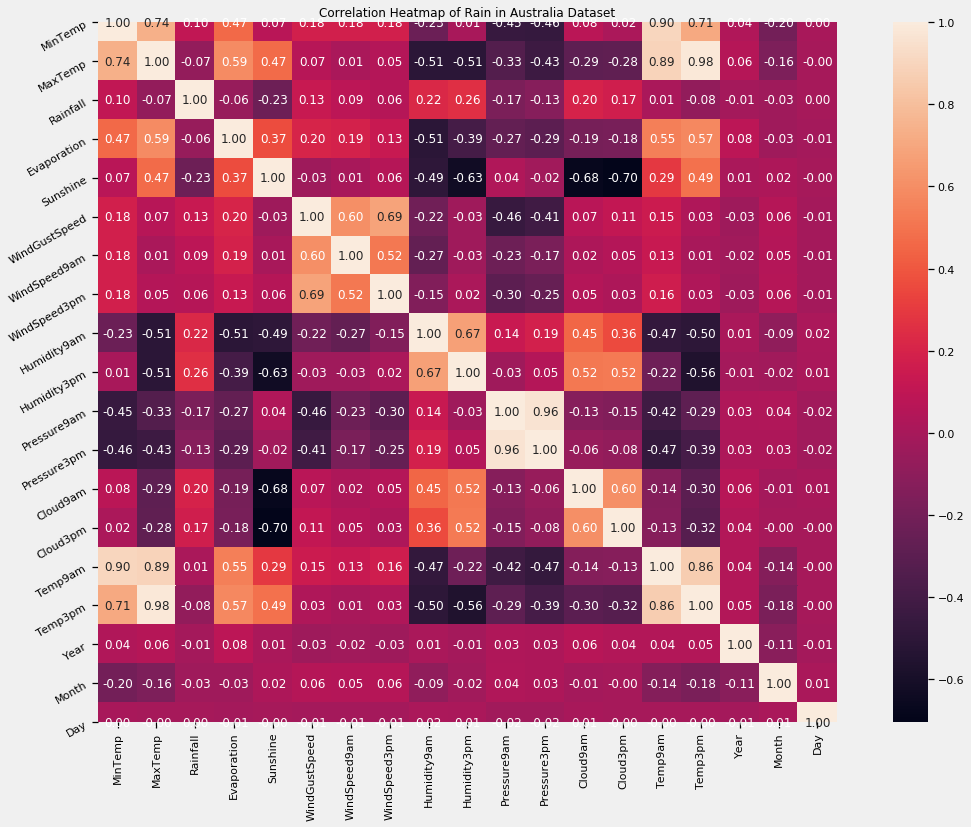

In [190]:
plt.figure(figsize=(18,12))
plt.title('Correlation Heatmap of Rain in Australia Dataset')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

Which can choose the ones with high correlation and do furtehr analysis to explore their relationships

In [48]:
num_var = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'WindGustSpeed', 'WindSpeed3pm', 'Pressure9am', 'Pressure3pm']

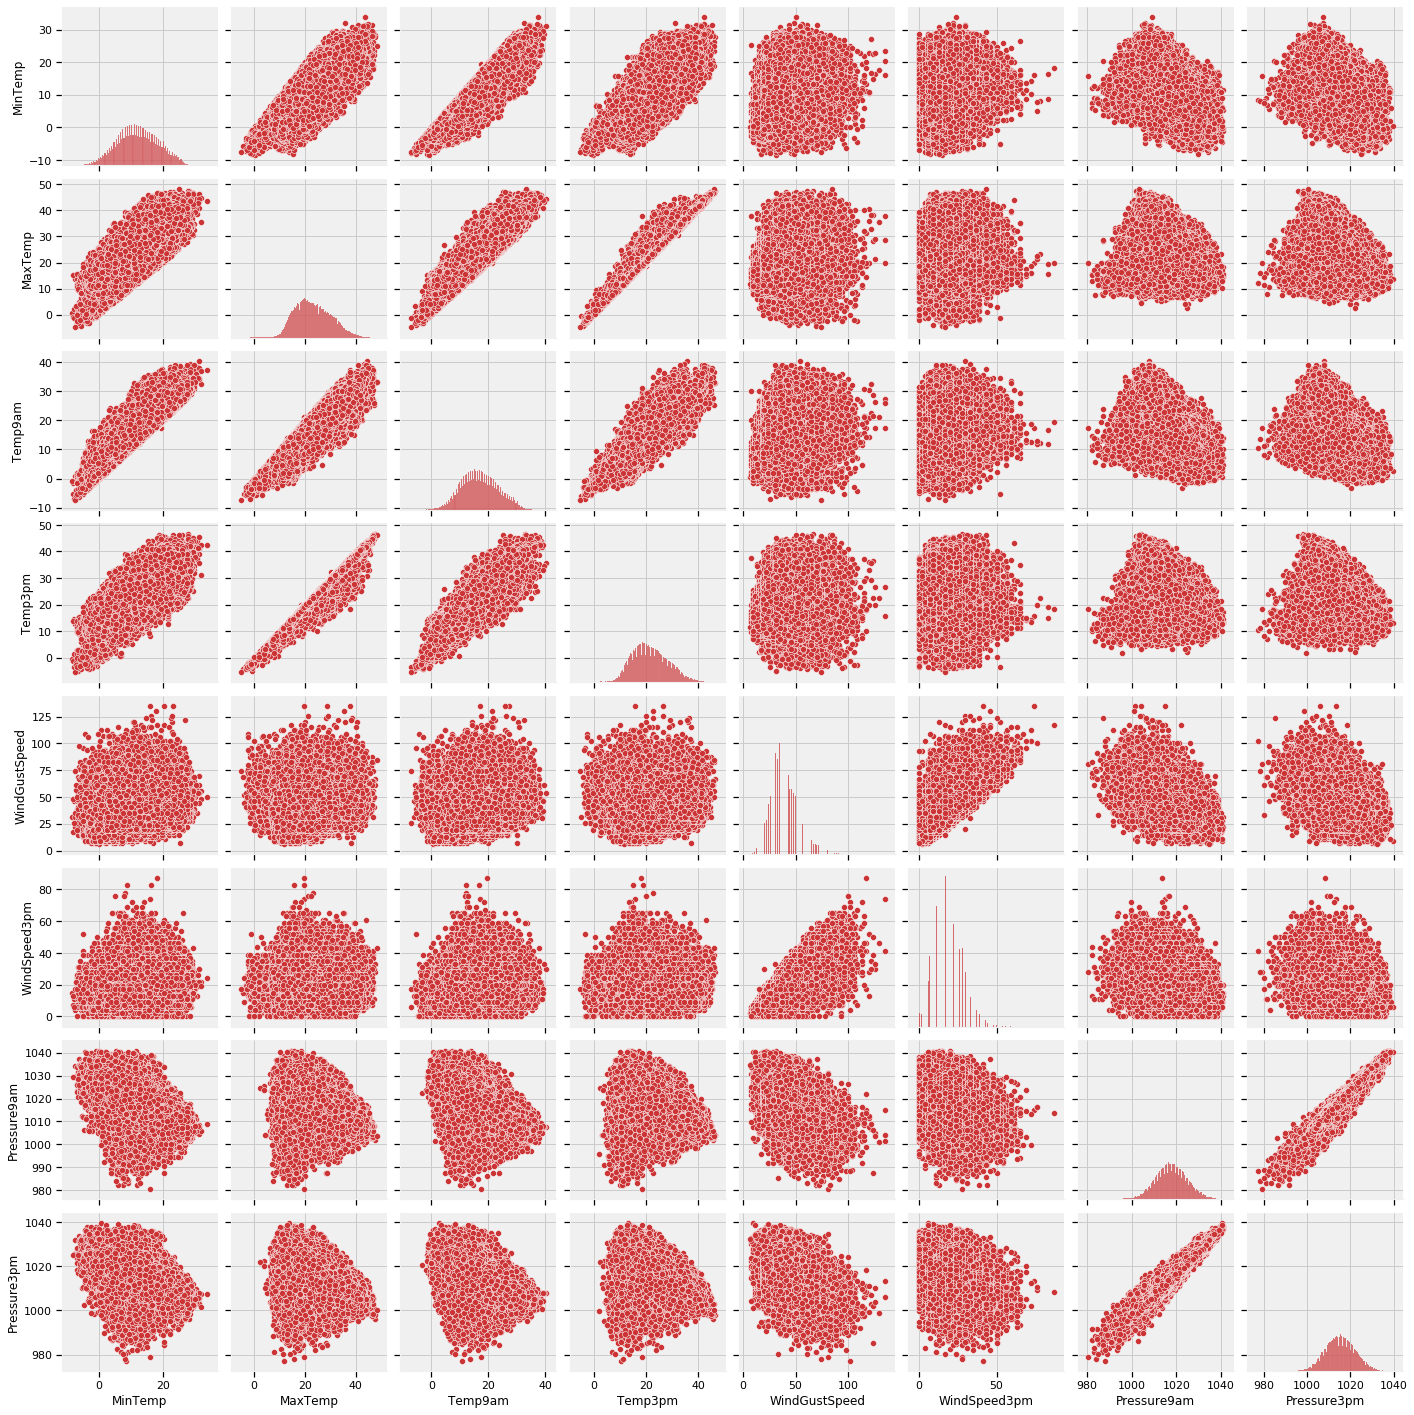

In [49]:
sns.pairplot(df[num_var], kind='scatter', diag_kind='hist', palette='Rainbow')
plt.show()

<a id='section2'></a>
## Feature Processing

First, we need to define the targetvariable and feature vector

In [145]:
X = df.drop(['RainTomorrow'], axis=1)

y = df['RainTomorrow']

Split X and y into training and testing sets

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [147]:
X_train.shape, X_test.shape

((113754, 24), (28439, 24))

### Numerical Features

In [148]:
numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

In [149]:
for col in numerical:
    if X_train[col].isnull().mean()>0:
        print(col, round(X_train[col].isnull().mean()*100,2), '%')

MinTemp 0.44 %
MaxTemp 0.23 %
Rainfall 1.0 %
Evaporation 42.83 %
Sunshine 47.75 %
WindGustSpeed 6.48 %
WindSpeed9am 0.95 %
WindSpeed3pm 1.84 %
Humidity9am 1.27 %
Humidity3pm 2.54 %
Pressure9am 9.86 %
Pressure3pm 9.83 %
Cloud9am 37.92 %
Cloud3pm 40.23 %
Temp9am 0.65 %
Temp3pm 1.91 %


There are different ways to deal with the missing values. For instance, if we assume that the missing data does not follow a specific pattern and has occured at random, we can simply replace the values with mean or median.

Note that you should treat the test data as if you cannot see it. So for filling the null values, you should use the statistical features of the training data.

In [150]:
for col in numerical:
    col_median=X_train[col].median()
    X_train[col].fillna(col_median, inplace=True)      
    X_test[col].fillna(col_median, inplace=True)  

Now let's remove the outliers

In [151]:
outlier_dic

{'Rainfall': 2.0,
 'Evaporation': 14.600000000000001,
 'WindSpeed9am': 37.0,
 'WindSpeed3pm': 40.5}

In [152]:
a = np.arange(10)
np.where(a < 5, a, 10*a)

array([ 0,  1,  2,  3,  4, 50, 60, 70, 80, 90])

In [153]:
for dataset in [X_train, X_test]:
    for name, max_val in outlier_dic.items():
        dataset[name] = np.where(dataset[name]>max_val, max_val, dataset[name])

### Categorical Features

In [155]:
categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']

In [156]:
for col in categorical:
    if X_train[col].isnull().mean()>0:
        print(col, round(X_train[col].isnull().mean()*100,2), '%')

WindGustDir 6.51 %
WindDir9am 7.01 %
WindDir3pm 2.64 %
RainToday 1.0 %


We can fill the missing values with the mode value

In [157]:
for dataset in [X_train, X_test]:
    dataset['WindGustDir'].fillna(X_train['WindGustDir'].mode()[0], inplace=True)
    dataset['WindDir9am'].fillna(X_train['WindDir9am'].mode()[0], inplace=True)
    dataset['WindDir3pm'].fillna(X_train['WindDir3pm'].mode()[0], inplace=True)
    dataset['RainToday'].fillna(X_train['RainToday'].mode()[0], inplace=True)

Now we need to encode the values into numbers

In [158]:
encoder = ce.BinaryEncoder(cols=['RainToday'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

In [159]:
X_train.columns[X_train.columns.str.contains('RainToday')]

Index(['RainToday_0', 'RainToday_1'], dtype='object')

We can also use the getdummies method

In [160]:
X_train.WindGustDir.unique()

array(['S', 'ENE', 'E', 'ESE', 'W', 'WSW', 'NNW', 'SSW', 'SW', 'SE', 'NE',
       'WNW', 'NW', 'NNE', 'SSE', 'N'], dtype=object)

In [161]:
pd.get_dummies(X_train.WindGustDir)

,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
113462,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
89638,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
138130,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
87898,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
16484,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43204,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
100206,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
98494,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
120883,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Let's do this for every categorical feature

In [162]:
X_train = pd.concat([X_train[numerical], X_train[['RainToday_0', 'RainToday_1']],
                     pd.get_dummies(X_train.Location), 
                     pd.get_dummies(X_train.WindGustDir),
                     pd.get_dummies(X_train.WindDir9am),
                     pd.get_dummies(X_train.WindDir3pm)], axis=1)
X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
113462,13.9,22.6,0.2,4.8,8.5,41.0,20.0,28.0,65.0,55.0,...,0,0,1,0,0,0,0,0,0,0
89638,22.4,29.4,2.0,6.0,6.3,33.0,7.0,19.0,71.0,59.0,...,0,0,0,1,0,0,0,0,0,0
138130,9.7,36.2,0.0,11.4,12.3,31.0,15.0,11.0,6.0,2.0,...,0,0,0,0,0,0,0,0,0,0
87898,20.5,30.1,0.0,8.8,11.1,37.0,22.0,19.0,59.0,53.0,...,0,0,0,0,0,0,0,0,0,0
16484,16.8,29.2,0.0,4.8,8.5,39.0,0.0,7.0,72.0,53.0,...,0,0,0,1,0,0,0,0,0,0


we need to do the same thing for the test data

In [163]:
X_test = pd.concat([X_test[numerical], X_test[['RainToday_0', 'RainToday_1']],
                     pd.get_dummies(X_test.Location), 
                     pd.get_dummies(X_test.WindGustDir),
                     pd.get_dummies(X_test.WindDir9am),
                     pd.get_dummies(X_test.WindDir3pm)], axis=1)


X_test.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
88578,17.4,29.0,0.0,3.6,11.1,33.0,11.0,19.0,63.0,61.0,...,0,0,0,0,0,0,0,0,0,0
59016,6.8,14.4,0.8,0.8,8.5,46.0,17.0,22.0,80.0,55.0,...,0,0,1,0,0,0,0,0,0,0
127049,10.1,15.4,2.0,4.8,8.5,31.0,13.0,9.0,70.0,61.0,...,0,0,0,0,1,0,0,0,0,0
120886,14.4,33.4,0.0,8.0,11.6,41.0,9.0,17.0,40.0,23.0,...,0,0,0,0,0,0,1,0,0,0
136649,6.8,14.3,2.0,0.2,7.3,28.0,15.0,13.0,92.0,47.0,...,0,0,0,0,0,0,0,0,0,0


### Scaling

It is very important to scale features before modeling. There is an article in the link below about its importance:
https://www.enjoyalgorithms.com/blog/need-of-feature-scaling-in-machine-learning

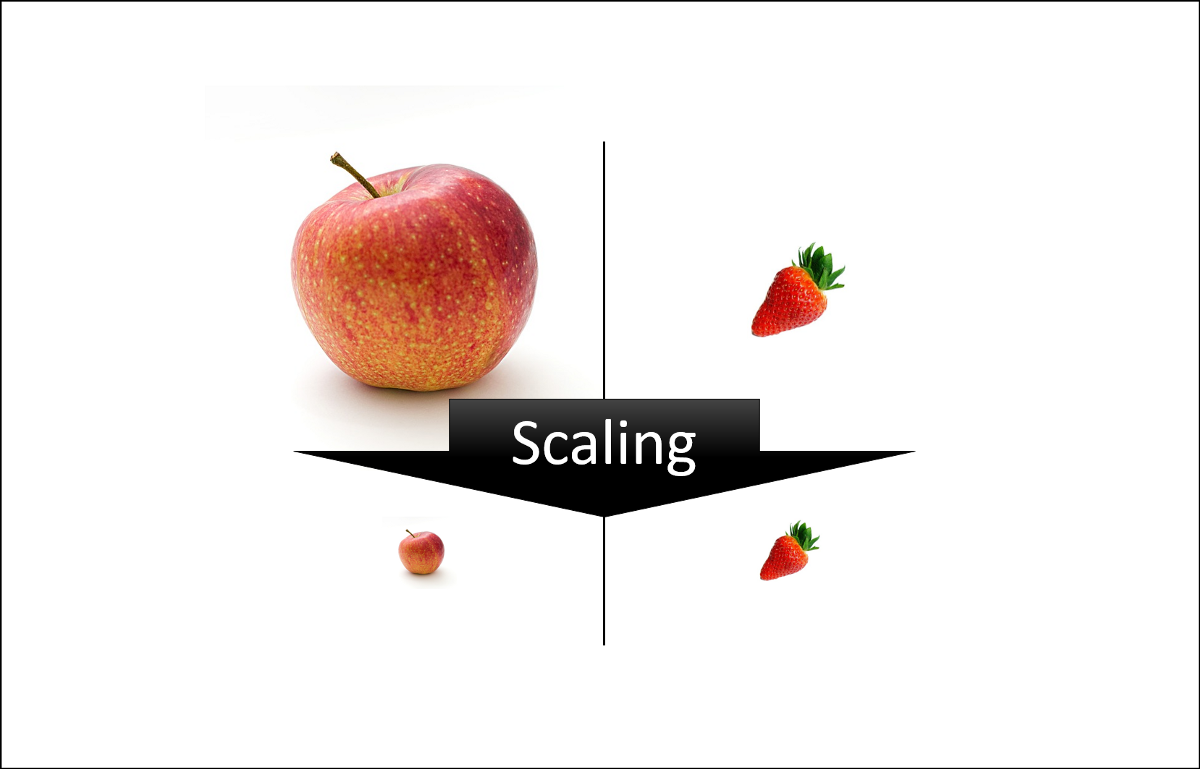

There are different ways to do the scaling, one common approach is to use minmax scaling which Transform features by scaling each feature to a given range (by default the range is 0-1).

In [164]:
cols = X_train.columns

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)


X_train = pd.DataFrame(X_train, columns=[cols])

X_test = pd.DataFrame(X_test, columns=[cols])

In [165]:
X_train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
count,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,...,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000
mean,0.484406,0.530004,0.240288,0.349526,0.554562,0.262667,0.375525,0.457641,0.688675,0.515095,...,0.054530,0.060288,0.067259,0.101605,0.064059,0.056402,0.064464,0.069334,0.060798,0.065483
std,0.151741,0.134105,0.394593,0.178451,0.190999,0.101682,0.230653,0.208353,0.189356,0.205307,...,0.227061,0.238021,0.250471,0.302130,0.244860,0.230698,0.245578,0.254022,0.238960,0.247378
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.375297,0.431002,0.000000,0.273973,0.565517,0.193798,0.189189,0.320988,0.570000,0.370000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.479810,0.517958,0.000000,0.328767,0.586207,0.255814,0.351351,0.469136,0.700000,0.520000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.593824,0.623819,0.300000,0.369863,0.600000,0.310078,0.513514,0.592593,0.830000,0.650000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a id='section3'></a>
# Model training

Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containing 64-bit
floats for optimal performance; any other input format will be converted
(and copied).

#### Solver?

Solvers are basically methods for minmizing the loss function in an optimized way.

For instance LIBLINEAR solver uses a Coordinate Descent (CD) algorithm that solves optimization problems by successively performing approximate minimization along coordinate directions or coordinate hyperplanes.

Have a look at this for more info: https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions#:~:text=It's%20a%20linear%20classification%20that,coordinate%20directions%20or%20coordinate%20hyperplanes.

Now let's instantiate the model with the liblinear solver:

In [168]:
logreg = LogisticRegression(solver='liblinear', random_state=0)

In [169]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

#### What is C?

Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

Regularization generally refers the concept that there should be a complexity penalty for more extreme parameters. The idea is that just looking at the training data and not paying attention to how extreme one's parameters are leads to overfitting. A high value of C tells the model to give high weight to the training data, and a lower weight to the complexity penalty. A low value tells the model to give more weight to this complexity penalty at the expense of fitting to the training data. Basically, a high C means "Trust this training data a lot", while a low value says "This data may not be fully representative of the real world data, so if it's telling you to make a parameter really large, don't listen to it".
credit: https://stackoverflow.com/questions/67513075/what-is-c-parameter-in-sklearn-logistic-regression

More info: https://en.wikipedia.org/wiki/Regularization_(mathematics)

now we can predict the X_test

In [170]:
y_pred_test = logreg.predict(X_test)

y_pred_test

array(['No', 'No', 'No', ..., 'No', 'No', 'Yes'], dtype=object)

We can also see how certain the model is in prediction:

In [171]:
logreg.predict_proba(X_test)

array([[0.91472371, 0.08527629],
       [0.82236891, 0.17763109],
       [0.83011968, 0.16988032],
       ...,
       [0.9769766 , 0.0230234 ],
       [0.8020197 , 0.1979803 ],
       [0.32630232, 0.67369768]])

Let's compare the performance of the model on the training set and the test set

In [174]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(logreg.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(logreg.score(X_test, y_test)))

Training set score: 0.8474
Test set score: 0.8495


<a id='section4'></a>
## Model Evaluation and performance metrics

There are differnt ways to evaluate your model. 

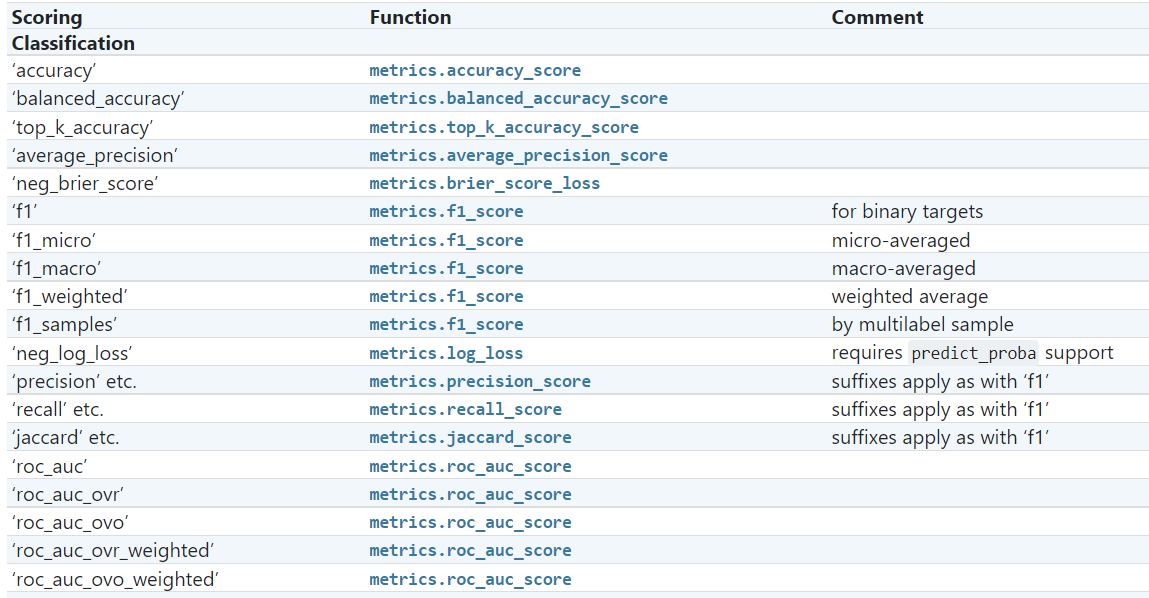

https://scikit-learn.org/stable/modules/model_evaluation.html

First, let's see how accurate our model is.

In [178]:
accuracy_score(y_test,y_pred_test)

0.8494672808467245

### Confusion Matrix, Percision, Recall, Sensitivity, Specificity

Four types of outcomes are possible when a classifier predicts on a test sample:

**True Positives (TP)** – True Positives occur when we predict an observation belongs to a certain class and the observation actually belongs to that class.

**True Negatives (TN)** – True Negatives occur when we predict an observation does not belong to a certain class and the observation actually does not belong to that class.

**False Positives (FP)** – False Positives occur when we predict an observation belongs to a certain class but the observation actually does not belong to that class. This type of error is called Type I error.

**False Negatives (FN)** – False Negatives occur when we predict an observation does not belong to a certain class but the observation actually belongs to that class. This is a very serious error and it is called Type II error.

In [185]:
pd.DataFrame(y_pred_test).value_counts()

No     23958
Yes     4481
dtype: int64

In [186]:
cm = confusion_matrix(y_test, y_pred_test)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

Confusion matrix

 [[20872  1195]
 [ 3086  3286]]

True Positives(TP) =  20872

True Negatives(TN) =  3286

False Positives(FP) =  1195

False Negatives(FN) =  3086


We can visualize these results

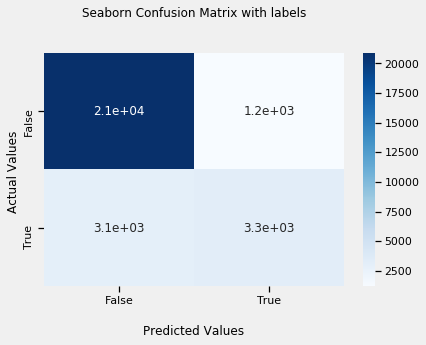

In [228]:
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
ax.set_ylim(2.0, 0)
## Display the visualization of the Confusion Matrix.
plt.show()

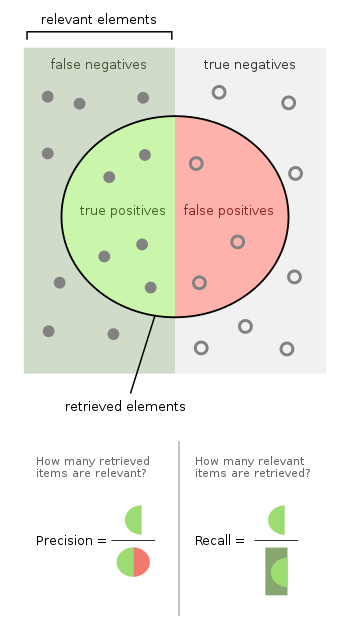

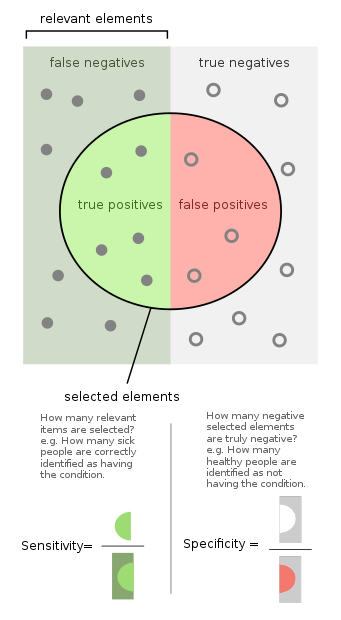

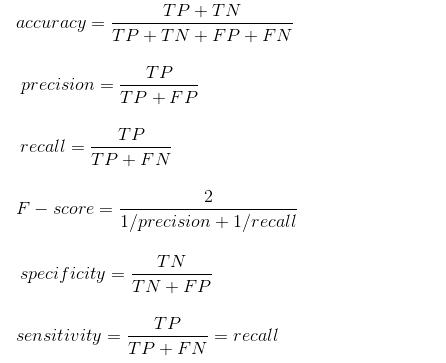

In [229]:
precision = TP / float(TP + FP)


print('Precision : {0:0.4f}'.format(precision))

Precision : 0.9458


In [230]:
recall = TP / float(TP + FN)

print('Recall or Sensitivity : {0:0.4f}'.format(recall))

Recall or Sensitivity : 0.8712


Now we can define new metrics based on these

In [234]:
f1_score(y_test, y_pred_test,average='macro')

0.756266093731083

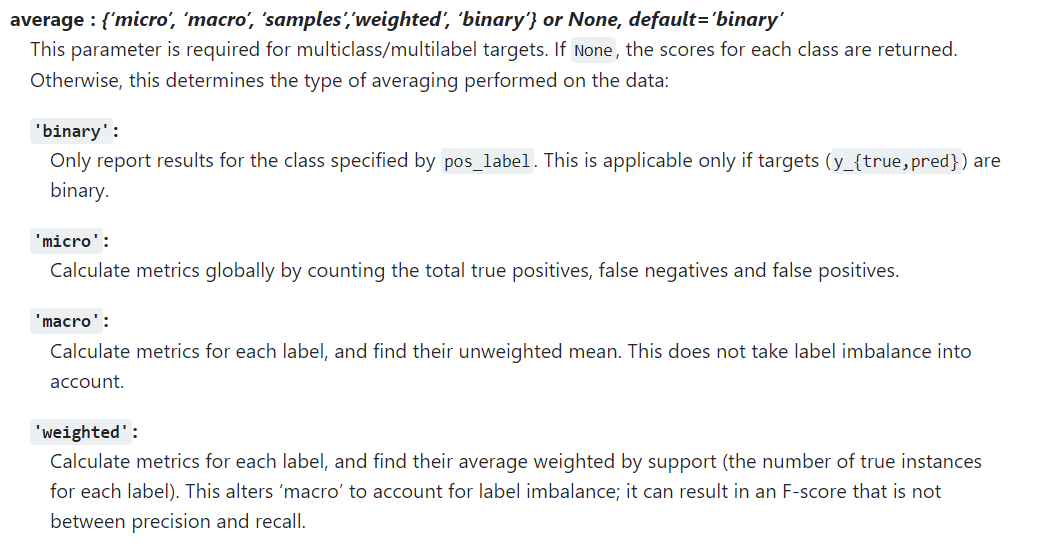

## How can we do better?

### Hyper-paramater Tuning and cross validation

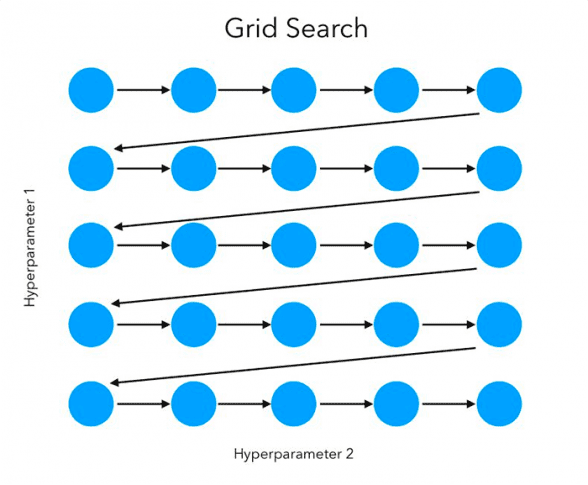

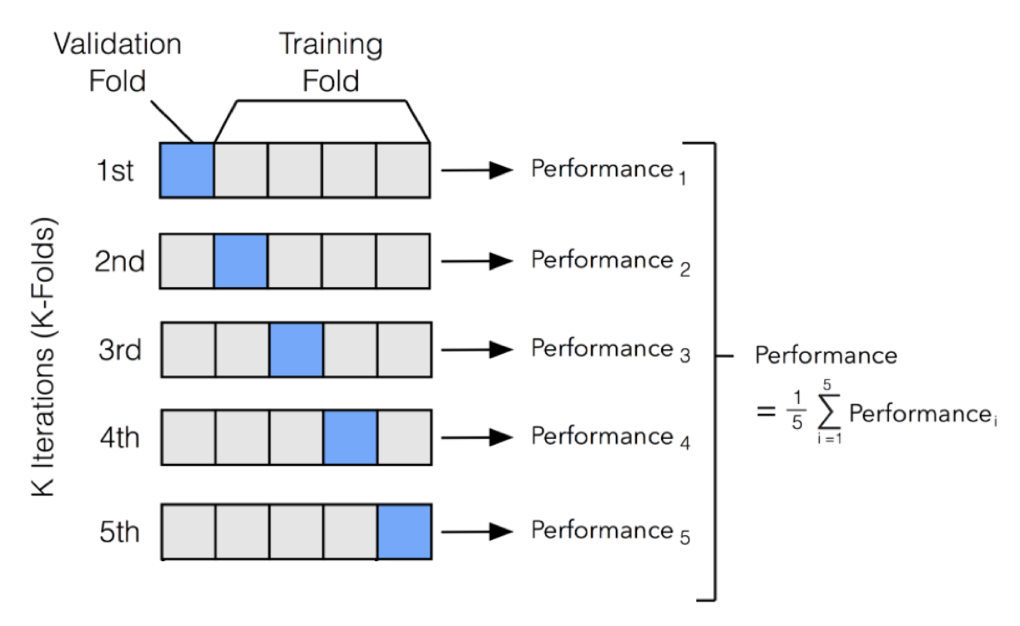

In [236]:
parameters = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]}]


grid_search = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 10, 100, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [237]:
# examine the best model

# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))

# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))

# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

GridSearch CV best score : 0.8470


Parameters that give the best results : 

 {'C': 1000}


Estimator that was chosen by the search : 

 LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [238]:
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(X_test, y_test)))

GridSearch CV score on test set: 0.8497
